In [2]:
import cv2
import os
#import tensorflow as tf
from keras.models import load_model
import numpy as np
from pygame import mixer
import time

pygame 2.5.1 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
mixer.init()
sound = mixer.Sound('alarm.wav')

face = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
leye = cv2.CascadeClassifier('haarcascade_lefteye_2splits.xml')
reye = cv2.CascadeClassifier('haarcascade_righteye_2splits.xml')

In [4]:
#labels to indicate state of eyes
lbl=['Close','Open']

#load saved model
model = load_model('model_CNN.h5')

#get current working directory
    
path = os.getcwd()

#access video camera
cap = cv2.VideoCapture(0)

#font of the displayed text
font = cv2.FONT_HERSHEY_COMPLEX_SMALL

#no of processed frames
count=0

#keep track of eye state
score=0

#border around the frame
thicc=2

#2 lists of both eye with initial value as open(1)
rpred=[1,0]
lpred=[1,0]
val1=1
val2=1


while(True):
    
    #ret for capture=true or false (successful) and frame for frame
    ret, frame = cap.read()
    
    #h and w of captured frame
    height,width = frame.shape[:2] 
    
    #color frame to b&w
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    
    #This line uses a Haar cascade classifier (face) to detect faces in the grayscale frame (gray). The detectMultiScale function is called with various parameters:
    #minNeighbors: Minimum neighbors required for a positive detection.
    #scaleFactor: Scale factor for image pyramid. It determines how much the image size is reduced at each image scale.
    #minSize: Minimum size of the detected face.
    faces = face.detectMultiScale(gray,minNeighbors=5,scaleFactor=1.1,minSize=(25,25))
    
    
    #detect left and right eye
    left_eye = leye.detectMultiScale(gray)
    right_eye =  reye.detectMultiScale(gray)

    
    #background for the text
    cv2.rectangle(frame, (0,height-50) , (200,height) , (0,0,0) , thickness=cv2.FILLED )

    #frame drawn around detected face
    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x,y) , (x+w,y+h) , (100,100,100) , 1 )



    for (x,y,w,h) in right_eye:
        r_eye=frame[y:y+h,x:x+w]
        #count of processed eyes
        count=count+1
        
        #converted to grayscale and reshaped according to input size of cnn model
        r_eye = cv2.cvtColor(r_eye,cv2.COLOR_BGR2GRAY)
        r_eye = cv2.resize(r_eye,(52,52))
        r_eye= r_eye/255
        r_eye=  r_eye.reshape(52,52,1)
        
        #predicts 
        rpred = model.predict(np.expand_dims(r_eye,axis=0))
        #closed
        if(rpred[0][0]>rpred[0][1]):
            val1=0
            lbl='Closed'
        
        #open
        else:
            val1=1
            lbl='Open'
        break
    
    
    #similar to right eye same steps are followed for left eye
    for (x,y,w,h) in left_eye:
        l_eye=frame[y:y+h,x:x+w]
        count=count+1
        l_eye = cv2.cvtColor(l_eye,cv2.COLOR_BGR2GRAY)  
        l_eye = cv2.resize(l_eye,(52,52))
        l_eye= l_eye/255
        l_eye=l_eye.reshape(52,52,1)
        lpred = model.predict(np.expand_dims(l_eye,axis=0))
        if(lpred[0][0]>lpred[0][1]):
            val2=0
            lbl='Closed'
        else:
            val2=1
            lbl='Open'
        break

        
    #if both eyes are closed, increment score and display "closed"
    if(val1==0 and val2==0):
        score=score+1
        cv2.putText(frame,"Closed",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
    #if open, then decrement and display "open"
    else:
        score=score-1
        cv2.putText(frame,"Open",(10,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
    #always 0 or above    
    if(score<0):
        score=0   
    cv2.putText(frame,'Score:'+str(score),(100,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
    #drowsy person detected
    if(score>15):
        #person is feeling sleepy so we beep the alarm
        #save image and play sound
        cv2.imwrite(os.path.join(path,'image.jpg'),frame)
        try:
            sound.play()
            
        except:  # isplaying = False
            pass
        
        # border thickens gradually when the "score" remains above 15 for extended periods.
        if(thicc<16):
            thicc= thicc+2
        else:
            thicc=thicc-2
            if(thicc<2):
                thicc=2
        cv2.rectangle(frame,(0,0),(width,height),(0,0,255),thicc) 
    cv2.imshow('Human Driver Drowsiness Detection System',frame)
    
    #press q to break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
sound.play()
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 54ms/step


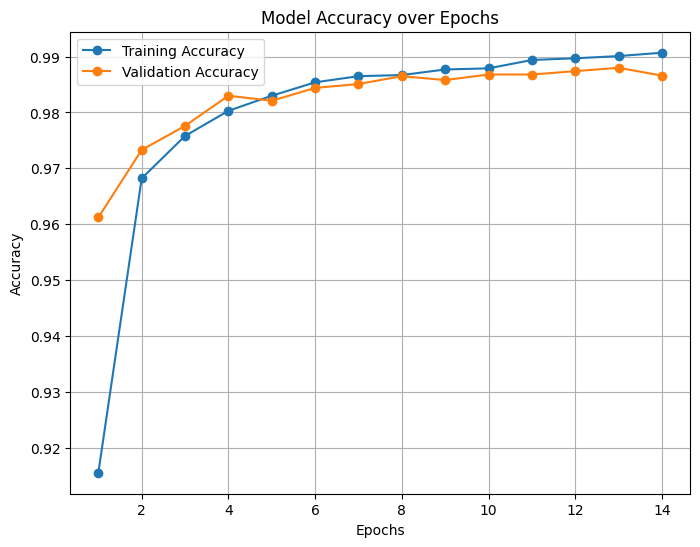

In [7]:
import matplotlib.pyplot as plt

# Accuracy values from the training log (you can replace with your actual values)
train_accuracy = [0.9155, 0.9682, 0.9758, 0.9803, 0.9830, 0.9854, 0.9865, 0.9867, 0.9877, 0.9879, 0.9894, 0.9897, 0.9901, 0.9907]
val_accuracy = [0.9612, 0.9733, 0.9776, 0.9830, 0.9821, 0.9844, 0.9851, 0.9865, 0.9858, 0.9868, 0.9868, 0.9874, 0.9880, 0.9866]

# Create a list of epoch numbers (x-axis)
epochs = list(range(1, len(train_accuracy) + 1))

# Create the accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy')
plt.plot(epochs, val_accuracy, marker='o', label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Results are added in the folder


# Conclusion
The code is useful for applications such as drowsiness detection, where it can help alert individuals when they are showing signs of drowsiness, potentially preventing accidents and improving safety. However, for the code to work correctly, you need to ensure that the required resources, including a trained CNN model, Haar cascade classifiers, and an alarm sound, are available and properly configured.



**Model Performance:** The final validation accuracy value (around 98.80%) indicates the model's ability to correctly classify data it has never seen before. It suggests that the model has achieved a high level of accuracy and is well-suited for its intended task.